# Chapter 5 Classification

In [4]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import warnings

import statsmodels.api as sm
from ISLP import load_data, confusion_table
from ISLP.models import (ModelSpec as MS, contrast, summarize)

from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

13. This question should be answered using the Weekly data set, which is part of the ISLP package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

Information about the dataset can be found [here](https://islp.readthedocs.io/en/main/datasets/Weekly.html)

Weekly percentage returns for the S&P 500 stock index between 1990 and 2010.

- **Year**: The year that the observation was recorded
- **Lag1**: Percentage return for previous week
- **Lag2**: Percentage return for 2 weeks previous
- **Lag3**: Percentage return for 3 weeks previous
- **Lag4**: Percentage return for 4 weeks previous
- **Lag5**: Percentage return for 5 weeks previous
- **Volume**: Volume of shares traded (average number of daily shares traded in billions)
- **Today**: Percentage return for this week
- **Direction**: A factor with levels ‘Down’ and ‘Up’ indicating whether the market had a positive or negative return on a given week.

In [8]:
data = load_data('Weekly')

(a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

In [6]:
data

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


In [9]:
data.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


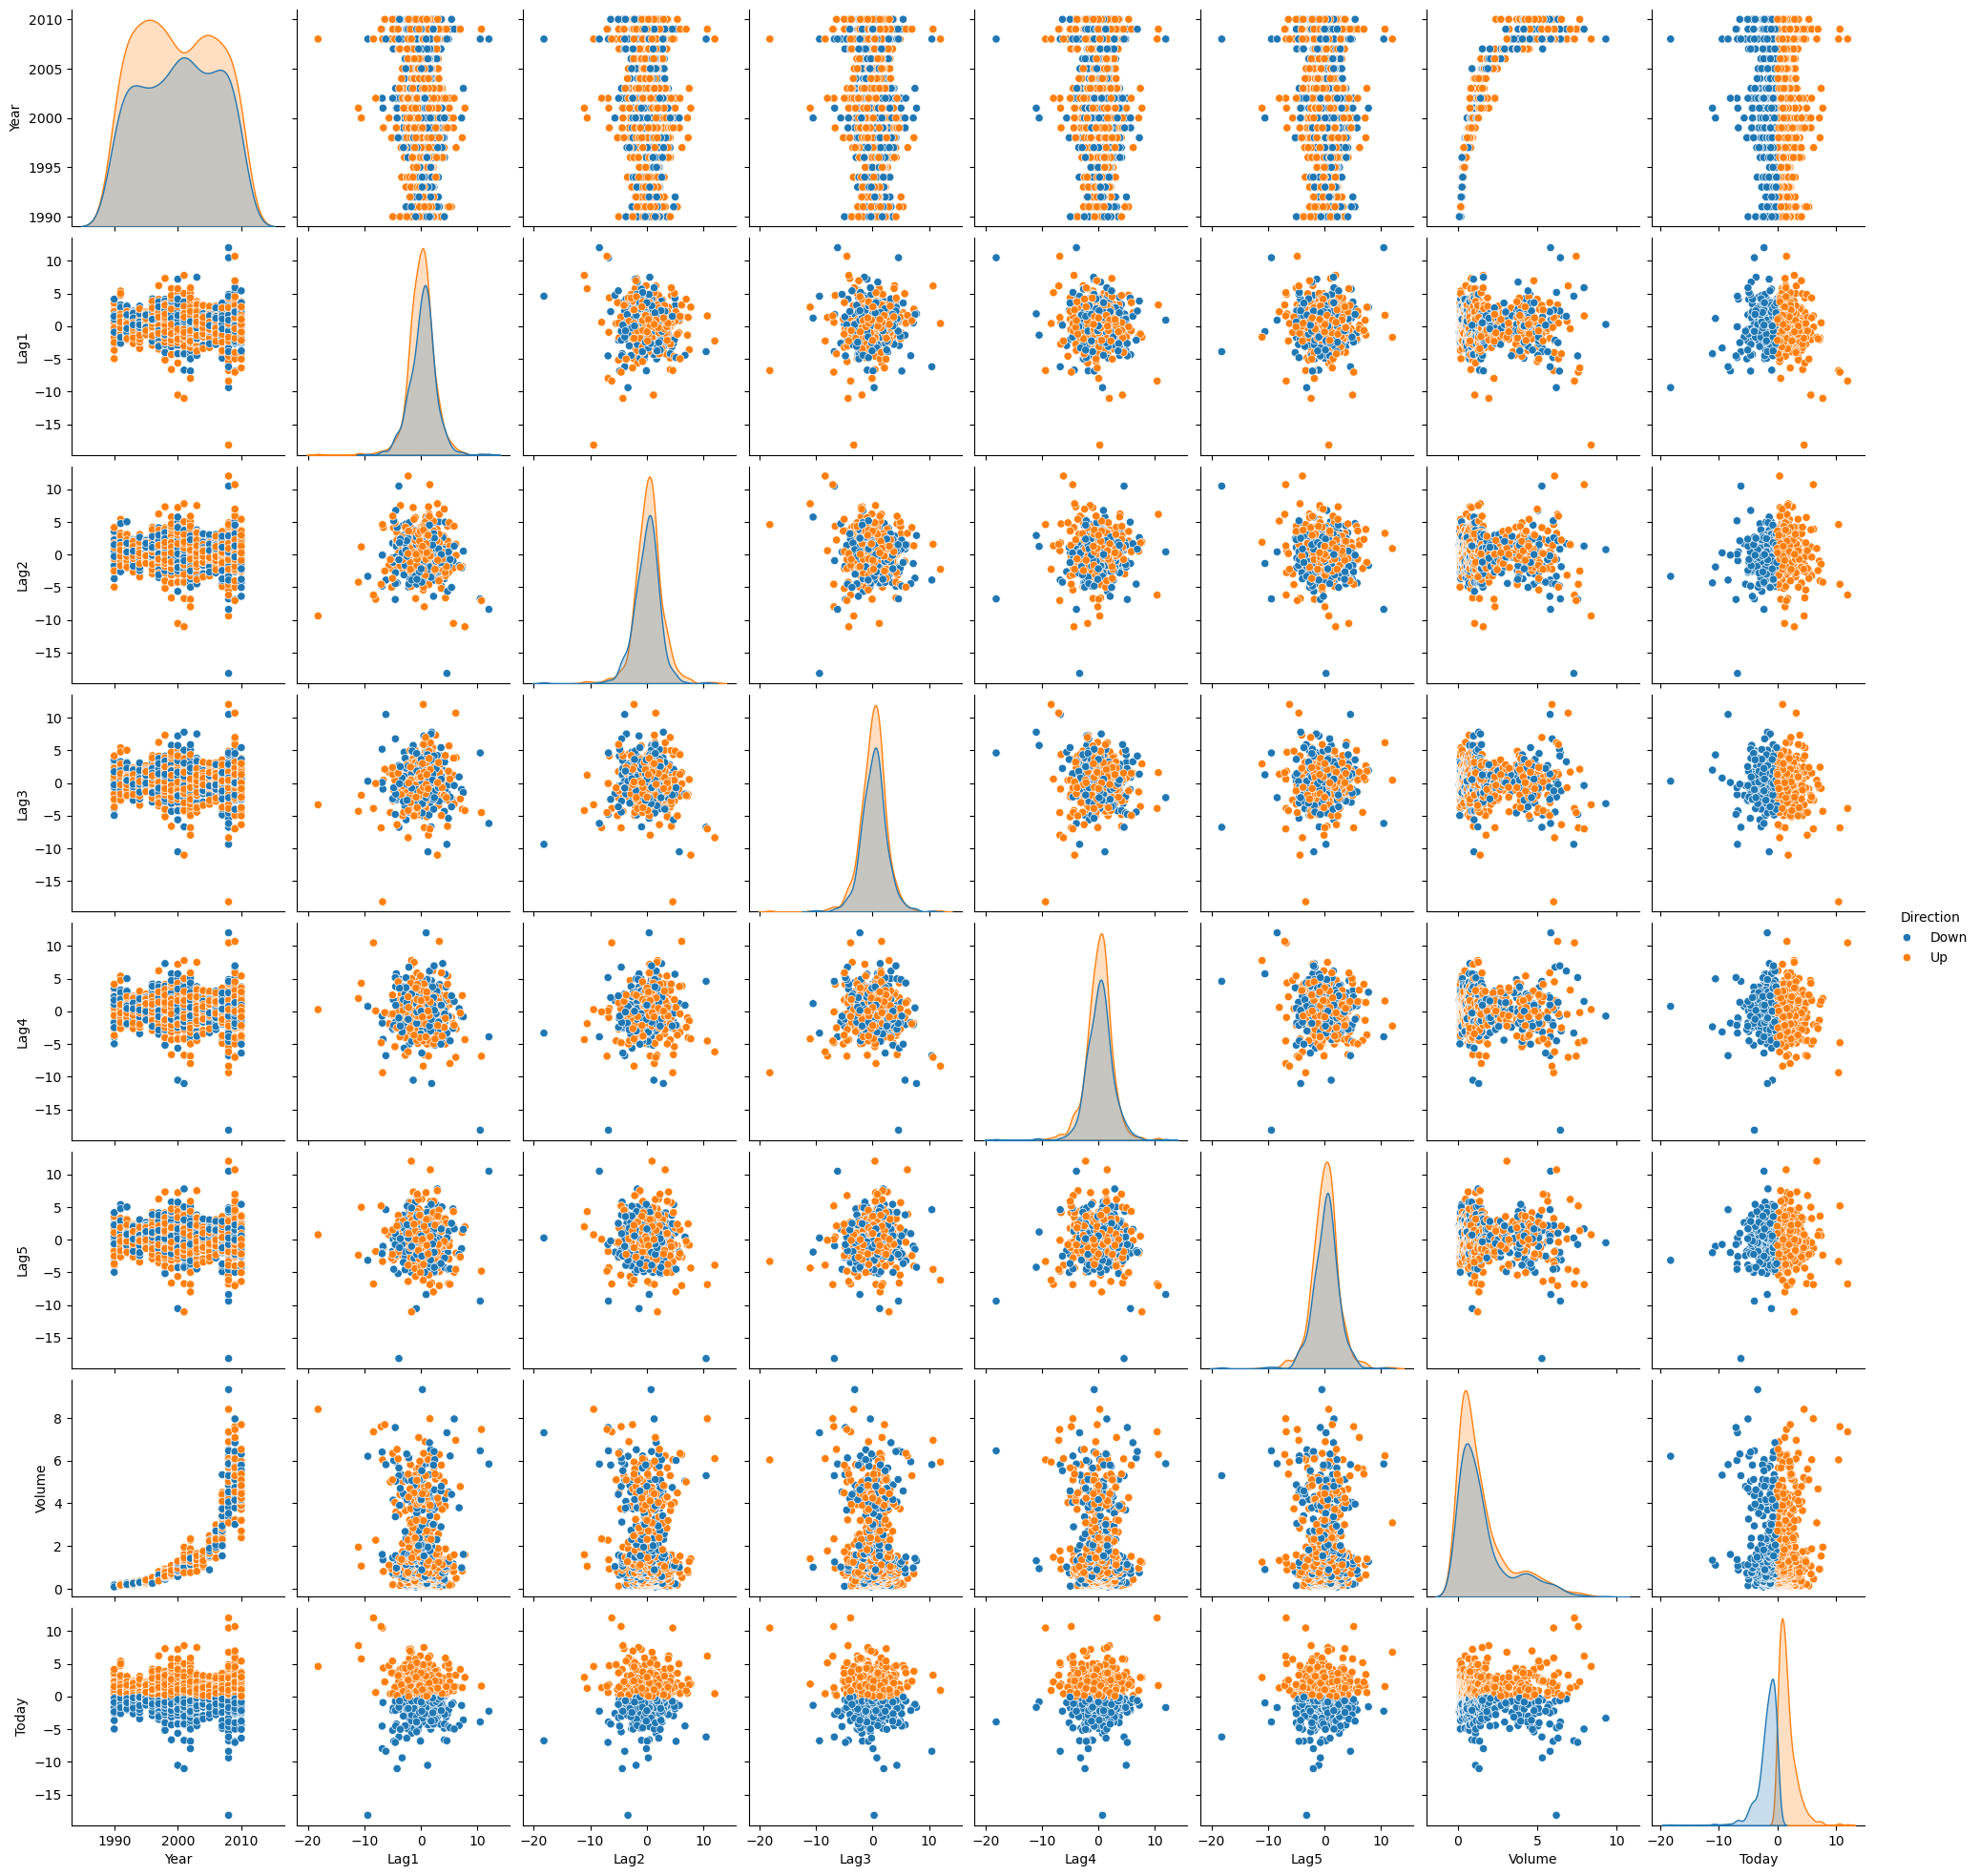

In [7]:
sns.pairplot(data, hue='Direction')

<Axes: ylabel='Lag1'>

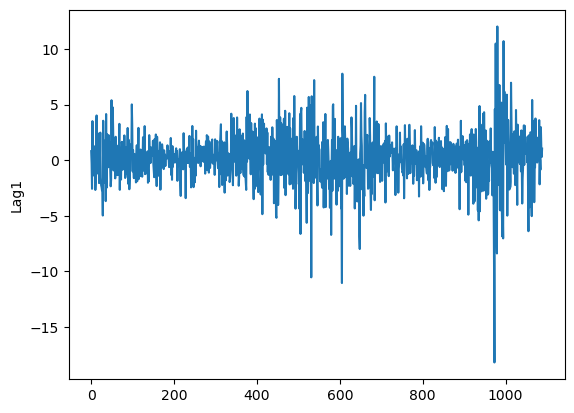

In [11]:
sns.lineplot(data.Lag1)

(b) Use the full data set to perform a logistic regression with
Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [43]:
X = MS(data.columns.drop(['Direction', 'Today', 'Year'])).fit_transform(data)
y = data['Direction'] == 'Up'

glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


Both Lag1 and Lag2 seem interesting

(c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [46]:
labels = np.array(["Down"]* data.shape[0])
labels[results.predict()>0.5] = 'Up'
confusion_table(labels, data.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [48]:
accuracy = np.mean(labels == data.Direction)
accuracy

0.5610651974288338

(d) Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [70]:
design = MS(['Lag2'])
X = design.fit_transform(data)
y = data.Direction == 'Up'

In [71]:
train = (data.Year < 2009)
data_train = data.loc[train]
data_test = data.loc[~train]
data_test.shape

(104, 9)

In [100]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [101]:
labels_test = np.array(['Down']*X_test.shape[0])
labels_test[probs>0.5] = 'Up' 

confusion_table(labels_test, data_test['Direction'])

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [102]:
np.mean(labels_test == data_test['Direction'])

0.625

(e) Repeat (d) using LDA.

In [103]:
lda = LDA(store_covariance=True)

lda.fit(X_train, y_train)

probs = lda.predict(X_test)

In [104]:
labels_test = np.array(['Down']*X_test.shape[0])
labels_test[probs>0.5] = 'Up' 

confusion_table(labels_test, data_test['Direction'])

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [105]:
np.mean(labels_test == data_test['Direction'])

0.625

(f) Repeat (d) using QDA.

In [106]:
qda = QDA(store_covariance=True)

qda.fit(X_train, y_train)

probs = qda.predict(X_test)

In [107]:
labels_test = np.array(['Down']*X_test.shape[0])
labels_test[probs>0.5] = 'Up' 

confusion_table(labels_test, data_test['Direction'])

Truth,Down,Up
Predicted,,
Down,43,61
Up,0,0


In [108]:
np.mean(labels_test == data_test['Direction'])

0.41346153846153844

(g) Repeat (d) using KNN with K = 1.

In [112]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)

probs = knn1.predict(X_test)

In [113]:
labels_test = np.array(['Down']*X_test.shape[0])
labels_test[probs>0.5] = 'Up' 

confusion_table(labels_test, data_test['Direction'])

Truth,Down,Up
Predicted,,
Down,21,30
Up,22,31


In [114]:
np.mean(labels_test == data_test['Direction'])

0.5

(h) Repeat (d) using naive Bayes.

In [116]:
NB = GaussianNB()
NB.fit(X_train, y_train)

probs = NB.predict(X_test)

In [117]:
labels_test = np.array(['Down']*X_test.shape[0])
labels_test[probs>0.5] = 'Up' 

confusion_table(labels_test, data_test['Direction'])

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [118]:
np.mean(labels_test == data_test['Direction'])

0.5865384615384616

(i) Which of these methods appears to provide the best results on this data?

(j) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

14. In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the Auto data set.

(a) Create a binary variable, mpg01, that contains a 1 if mpg contains a value above its median, and a 0 if mpg contains a value below its median. You can compute the median using the median() method of the data frame. Note you may find it helpful to add a column mpg01 to the data frame by assignment. Assuming you have stored the data frame as Auto, this can be done as follows:
Auto['mpg01'] = mpg01

In [121]:
auto = load_data('Auto')
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [122]:
auto.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower        int64
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

In [125]:
auto['mpg01'] = np.where(auto['mpg']>np.median(auto['mpg']), 1, 0)

In [126]:
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,0
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl,1
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup,1
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage,1
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger,1


(b) Explore the data graphically in order to investigate the association between mpg01 and the other features. Which of the other features seem most likely to be useful in predicting mpg01? Scatterplots and boxplots may be useful tools to answer this question. Describe your findings.

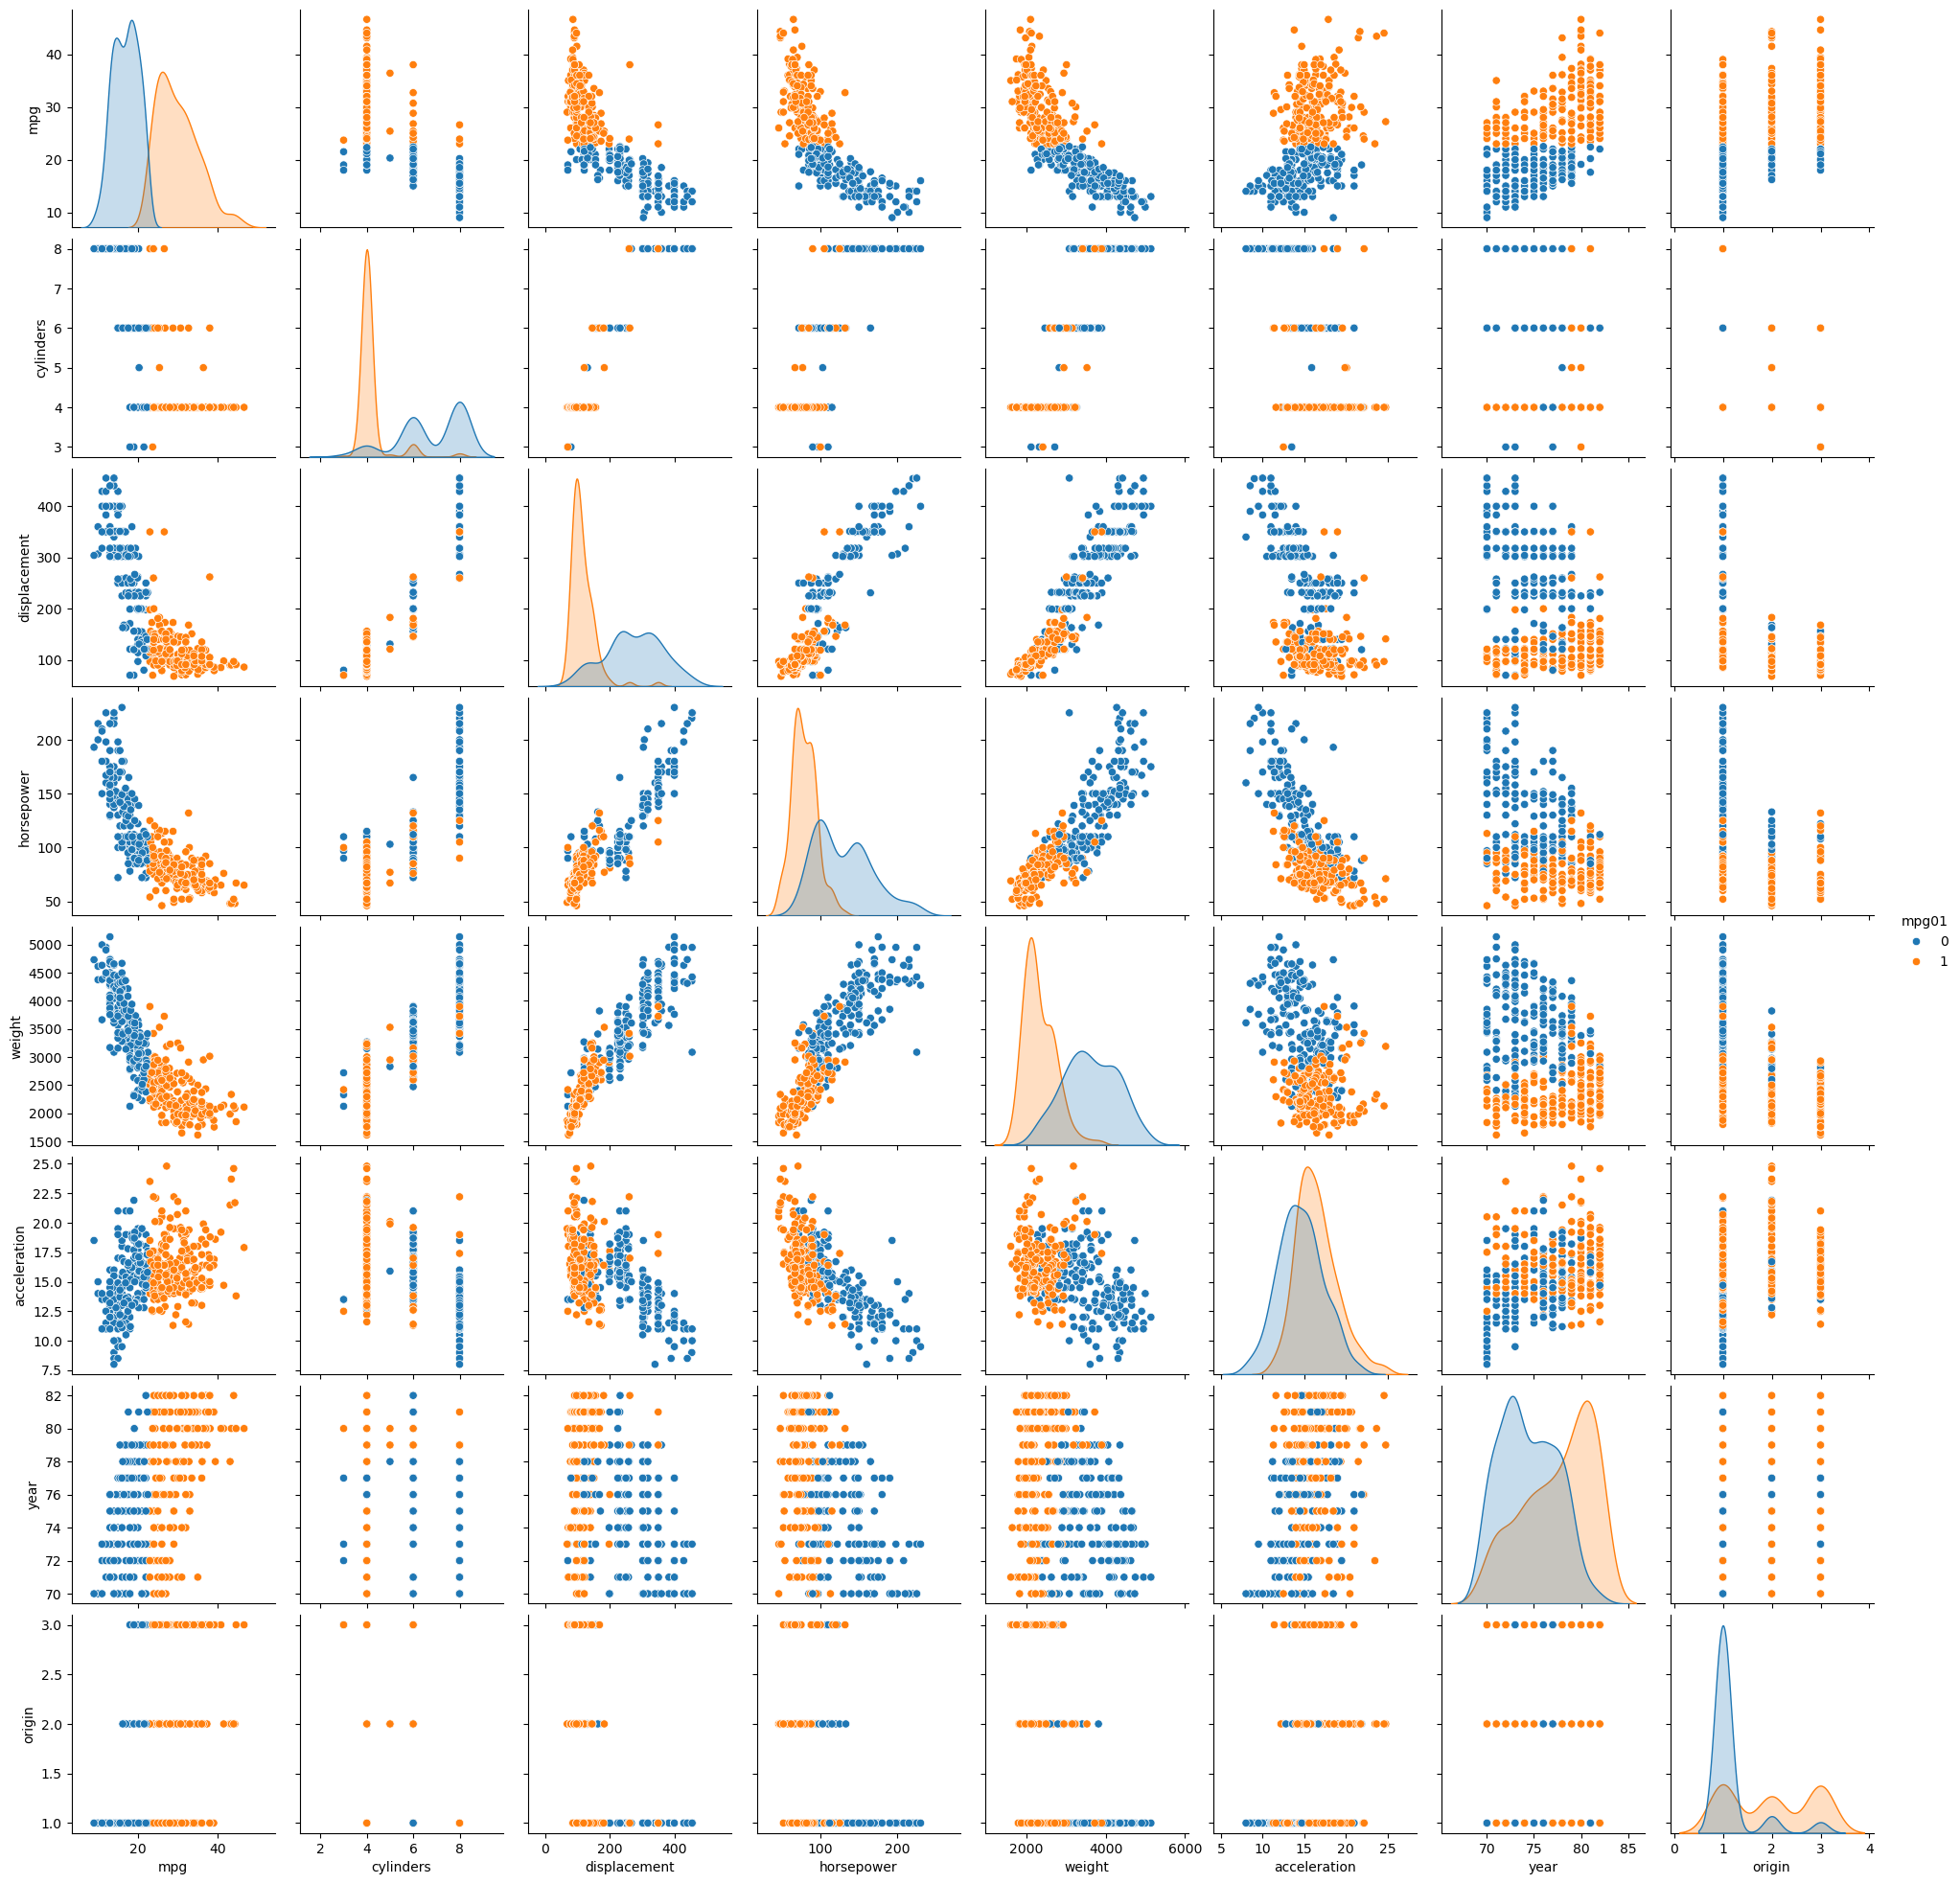

In [129]:
sns.pairplot(auto, hue='mpg01')

Based on the density functions shown in the diagonal of the pairplot cylinders, displacement and witght seem to be the most suitable features to build a classifier on top of.

(c) Split the data into a training set and a test set.

In [130]:
X_train, X_test, y_train, y_test = train_test_split(
    auto[['cylinders','displacement','weight']], auto['mpg01'], test_size=0.33, random_state=42)


(d) Perform LDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [131]:
lda = LDA(store_covariance=True)

lda.fit(X_train, y_train)

probs = lda.predict(X_test)

In [134]:
labels_test = np.array([0]*X_test.shape[0])
labels_test[probs>0.5] = 1 

confusion_table(labels_test, y_test)

Truth,0,1
Predicted,,
0,52,2
1,18,58


In [136]:
np.mean(labels_test == y_test)

0.8461538461538461

(e) Perform QDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [137]:
qda = QDA(store_covariance=True)

qda.fit(X_train, y_train)

probs = qda.predict(X_test)

In [138]:
labels_test = np.array([0]*X_test.shape[0])
labels_test[probs>0.5] = 1 

confusion_table(labels_test, y_test)

Truth,0,1
Predicted,,
0,56,2
1,14,58


In [139]:
np.mean(labels_test == y_test)

0.8769230769230769

(f) Perform logistic regression on the training data in order to pre- dict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

(g) Perform naive Bayes on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

(h) Perform KNN on the training data, with several values of K, in order to predict mpg01. Use only the variables that seemed most associated with mpg01 in (b). What test errors do you obtain? Which value of K seems to perform the best on this data set?

15. This problem involves writing functions.

(a) Write a function, Power(), that prints out the result of raising 2 to the 3rd power. In other words, your function should compute 23 and print out the results.

_Hint: Recall that x**a raises x to the power a. Use the print() function to display the result._

In [141]:
def Power():
    print(2*2*2)

Power()

8


(b) Create a new function, Power2(), that allows you to pass any two numbers, x and a, and prints out the value of x^a. You can do this by beginning your function with the line

    def Power2(x, a):

You should be able to call your function by entering, for instance,

    Power2(3, 8)

on the command line. This should output the value of 38, namely, 6, 561.

In [149]:
def Power2(x, a):
    result = x
    for a in range(a-1):
        result = result*x
    return result



2248091

(c) Using the Power2() function that you just wrote, compute 103, 817, and 1313.

In [150]:
print(f'Power2(10,3): {Power2(10,3)}')
print(f'Power2(8,17): {Power2(8,17)}')
print(f'Power2(131,3): {Power2(131,3)}')

Power2(10,3): 1000
Power2(8,17): 2251799813685248
Power2(131,3): 2248091


(d) Now create a new function, Power3(), that actually returns the result x^a as a Python object, rather than simply printing it
to the screen. That is, if you store the value x**a in an object called result within your function, then you can simply return return this result, using the following line:
  return result
Note that the line above should be the last line in your function, and it should be indented 4 spaces.

In [152]:
def Power3(x, a):
    result = x**a
    return result

(e) Now using the Power3() function, create a plot of f(x) = x2. The x-axis should display a range of integers from 1 to 10, and the y-axis should display x2. Label the axes appropriately, and use an appropriate title for the figure. Consider displaying either the x-axis, the y-axis, or both on the log-scale. 

You can do this by using the ax.set_xscale() and ax.set_yscale() methods of the axes you are plotting to.

In [154]:
x = np.linspace(0,10, 100)
y = Power3(x, 2)

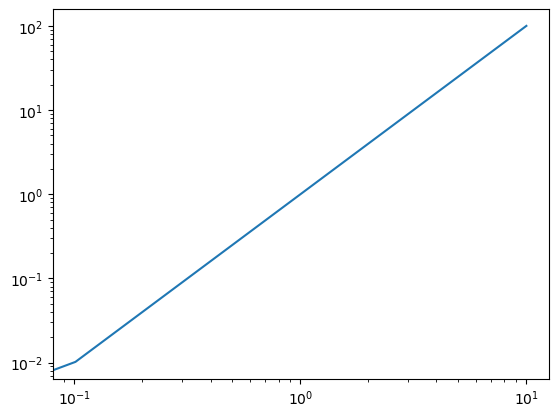

In [158]:
g = sns.lineplot(x=x, y=y)
g.set_xscale('log')
g.set_yscale('log')

(f) Create a function, PlotPower(), that allows you to create a plot of x against x**a for a fixed a and a sequence of values of x. For instance, if you call
PlotPower(np.arange(1, 11), 3)
then a plot should be created with an x-axis taking on values 1,2,...,10, and a y-axis taking on values 13,23,...,103.

16. Using the Boston data set, fit classification models in order to predict whether a given suburb has a crime rate above or below the median. Explore logistic regression, LDA, naive Bayes, and KNN models using various subsets of the predictors. Describe your findings.
Hint: You will have to create the response variable yourself, using the variables that are contained in the Boston data set.